In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from os.path import isfile
from glob import glob
from datetime import datetime, timedelta

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import gaussian_kde, skew

import matplotlib.pyplot as plt

In [2]:
obdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/observations/'
profdir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/era5/profiles/'

In [3]:
flist = glob(obdir + 'clean/*.pd')

# This can be a manual site list if desired
site_list = [f.split('/')[-1].split('_')[0] for f in flist]
site_list

['CLN', 'ALTA', 'AGD', 'BCC', 'SLB', 'PVC']

# Build into a loop over all stations

In [4]:
# for site in site_list:
site = 'ALTA'

### Obtain the metadata

In [5]:
meta_file = glob(obdir + '*Metadata*.xlsx')[0]
metadata = pd.read_excel(meta_file).set_index('code').loc[site]

# Determine the lat, lon of the site from the metadata
site_lat, site_lon = metadata['lat'], metadata['lon']
site_elev = metadata['elevation_m']

metadata

name                                                   Alta CoOp
owner                                   National Weather Service
city                                                        Alta
state                                                         UT
lat                                                      40.5906
lon                                                     -111.637
elevation_m                                                 2655
start                                                        NaN
end                                                          NaN
interval                                                      24
n_events                                                     NaN
auto_manual                                               Manual
snow_type                                                    NaN
swe_type                                                     NaN
notes          24h Precip observed at 1600 in earlier record,...
Name: ALTA, dtype: object

### Import the ERA5 Profile

In [6]:
# Import the era5_orog file to check the lat/lon grid
era_dir = '/uufs/chpc.utah.edu/common/home/steenburgh-group10/mewessler/era5/'
era5_orog_file = era_dir + 'era5_orog.nc'
era5_orog = xr.open_dataset(era5_orog_file)['z'].isel(time=0)
era5_orog = era5_orog.rename({'latitude':'lat', 'longitude':'lon'})
era5_lat, era5_lon = era5_orog['lat'], era5_orog['lon']

# Find the index of the correct lat lon
idx1d = (np.abs(era5_lon - site_lon) + np.abs(era5_lat - site_lat))
idx = np.unravel_index(np.argmin(idx1d, axis=None), idx1d.shape)

# Subset and convert gpm to m
era5_g = 9.80665
era5_orog = era5_orog.isel(lat=idx[1], lon=idx[0])/era5_g

era5_lat, era5_lon = era5_orog['lat'].values, era5_orog['lon'].values
era5_elev = era5_orog.values

print('ERA5 Profile:\n%.2f %.2f %.2f\n'%(era5_lat, era5_lon, era5_elev))

era5_prof_file = 'era5prof_{}N_{}W.nc'.format(
    era5_orog['lat'].values, abs(era5_orog['lon'].values))

if isfile(era_dir + 'profiles/' + era5_prof_file):
    era5_prof = xr.open_dataset(era_dir + 'profiles/' + era5_prof_file).load()
    print(era5_prof)
    
else:
    print('ERA5 Profile Missing:\n%s'%era5_prof_file)

ERA5 Profile:
40.50 -111.75 1967.42

<xarray.Dataset>
Dimensions:  (level: 23, time: 346224)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 ... 2019-06-30T23:00:00
  * level    (level) float64 200.0 225.0 250.0 300.0 ... 925.0 950.0 975.0 1e+03
Data variables:
    Q        (time, level) float32 8.430327e-06 2.2606831e-05 ... 0.0056080474
    T        (time, level) float32 213.56236 213.23013 ... 302.55365 303.83582
    U        (time, level) float32 32.258484 38.37195 ... -0.18589783
    V        (time, level) float32 2.0954742 2.2194977 ... 4.7066345 4.6651
    VO       (time, level) float32 6.204704e-06 ... -0.000121165765
    W        (time, level) float32 0.017477036 0.077495575 ... -0.11104393
    Z        (time, level) float32 115597.81 108389.75 ... 3440.6726 1319.3672
    R        (time, level) float32 23.817059 75.24865 ... 28.302814 28.428883
    U100M    (time) float32 -0.80430603 -0.3778534 ... 0.10606384 -0.1478424
    V100M    (time) float32 3.1638489 2.974456

### Import the surface observations

In [7]:
try:
    obs = pd.read_pickle(glob(obdir + 'clean/%s*.pd'%site)[0]).reset_index().rename(
        columns={'index':'time'}).set_index('time')
except:
    obs = pd.read_pickle(glob(obdir + 'clean/%s*.pd'%site)[0]).reset_index().rename(
        columns={'datetime_utc':'time'}).set_index('time')

obs = obs[obs.index > datetime(1980, 8, 1)]
    
print(obs.shape)
obs[:10]

(14269, 8)


,slr24,swe24_mm,snow24_mm,depth24_mm,tsfc_max_degC,tsfc_min_degC,tsfc_degC,precip_periods
time,,,,,,,,
1980-08-01 11:00:00,NaN,0.0,0.0,0.0,22.78,11.67,13.33,[]
1980-08-02 11:00:00,NaN,0.0,0.0,0.0,21.67,10.00,12.78,[]
1980-08-03 11:00:00,NaN,0.0,0.0,0.0,21.11,8.89,12.78,[]
1980-08-04 11:00:00,NaN,0.0,0.0,0.0,16.11,2.22,3.33,[]
1980-08-05 11:00:00,NaN,0.0,0.0,0.0,18.33,3.33,12.22,[]
1980-08-06 11:00:00,NaN,0.0,0.0,0.0,24.44,10.00,12.78,[]
1980-08-07 11:00:00,NaN,0.0,0.0,0.0,25.00,11.11,12.78,[]
1980-08-08 11:00:00,NaN,0.0,0.0,0.0,24.44,11.11,13.33,[]
1980-08-09 11:00:00,NaN,0.0,0.0,0.0,25.00,11.67,13.33,[]


### Prune observations based on minimum qpf, snow, and max T 

In [8]:
try:
    print('12h Data Used to Constrain SWE/SNOW')
    obs = obs[((obs['swe12_mm'] > 1.4) & (obs['snow12_mm'] >= 25.5))]
except:
    print('24h Data Used to Constrain SWE/SNOW')
    obs = obs[((obs['swe24_mm'] > 2.8) & (obs['snow24_mm'] >= 51.0))]

print(obs.shape)
obs[:10]

12h Data Used to Constrain SWE/SNOW
24h Data Used to Constrain SWE/SNOW
(2144, 8)


,slr24,swe24_mm,snow24_mm,depth24_mm,tsfc_max_degC,tsfc_min_degC,tsfc_degC,precip_periods
time,,,,,,,,
1980-10-15 11:00:00,8.695652,29.21,254.0,279.4,5.00,-4.44,-3.89,[]
1980-10-16 11:00:00,6.943685,18.29,127.0,406.4,-1.11,-5.56,-4.44,[]
1980-10-17 11:00:00,8.571429,35.56,304.8,736.6,-3.33,-5.56,-4.44,[]
1980-10-18 11:00:00,6.978022,10.92,76.2,635.0,-0.56,-6.11,-5.00,[]
1980-10-27 11:00:00,13.894967,9.14,127.0,127.0,-0.56,-6.11,-5.56,[]
1980-11-12 11:00:00,2.040707,37.34,76.2,76.2,8.89,-0.56,0.56,[]
1980-11-13 11:00:00,7.016575,28.96,203.2,254.0,2.22,-7.78,-6.67,[]
1980-11-14 11:00:00,20.819672,6.10,127.0,355.6,-1.67,-10.00,-10.00,[]
1980-11-23 11:00:00,6.943685,18.29,127.0,304.8,-2.78,-9.44,-9.44,[]


### Investigate the data with a few plots

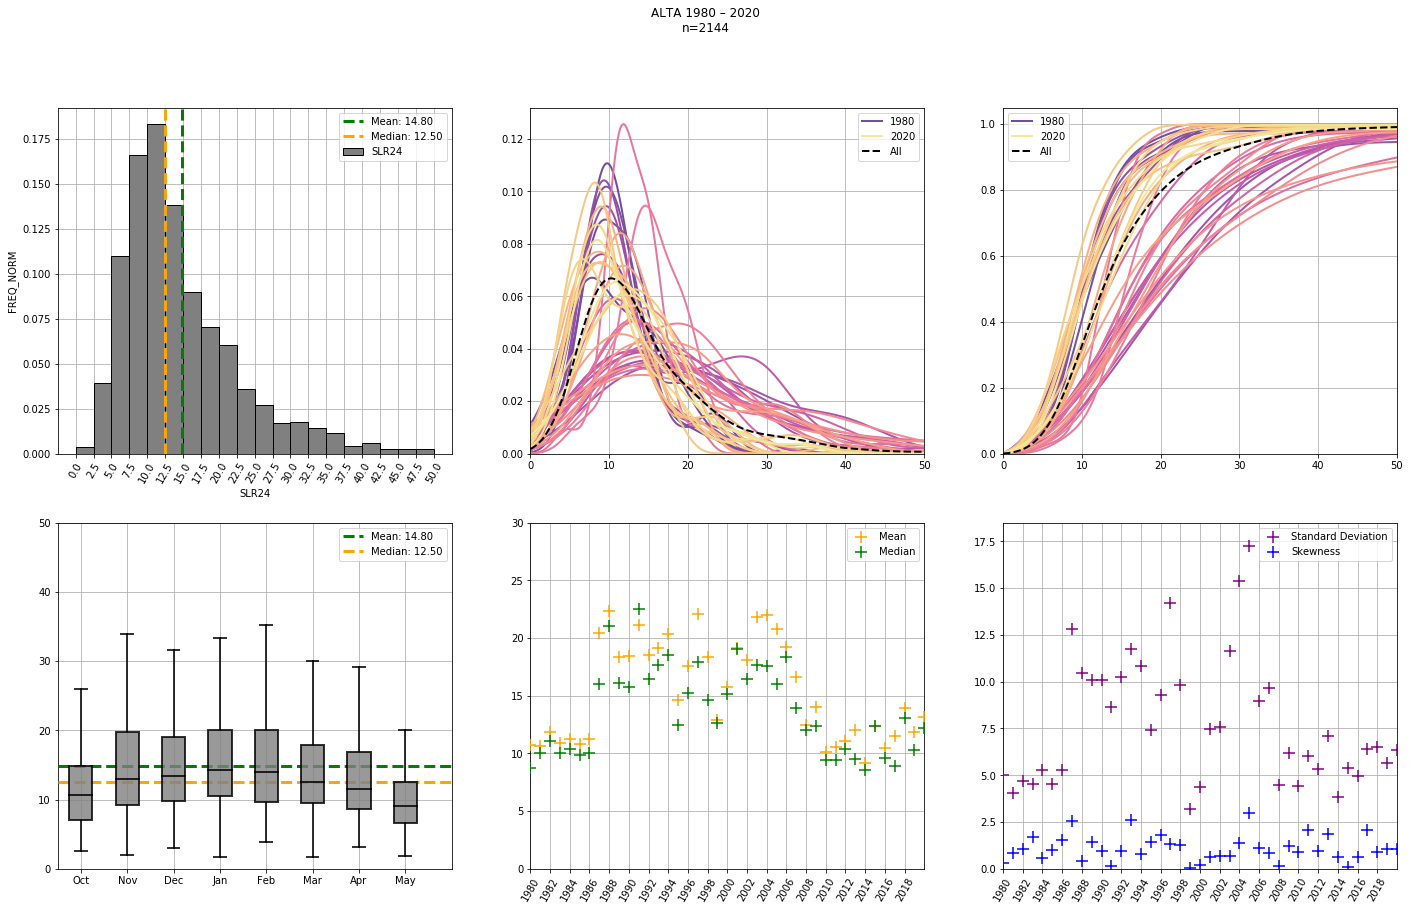

In [9]:
ycolors = ("#704D9E","#704D9E","#7A4EA0","#824EA3","#8B4FA4","#9350A6","#9B51A7","#A253A8","#AA54A9",
           "#B156A9","#B758A9","#BE5AA9","#C45DA8","#CA60A7","#CF63A6","#D566A4","#DA6AA3","#DE6DA1",
           "#E3719E","#E7759C","#EB7A99","#EE7F96","#F18493","#F28A90","#F48F8D","#F5958B","#F79A88",
           "#F7A086", "#F8A684","#F9AB83","#F9B182","#F9B681","#F9BC81","#F9C182","#F8C783","#F8CC85",
           "#F7D288","#F6D78B","#F5DC8F","#F4E294","#F3E79A")

binwidth = 2.5

for k in [k for k in obs if 'slr' in k]:

    fig, axs = plt.subplots(2, 3, figsize=(24, 14), facecolor='w')
    axs = axs.flatten()
    ax1, ax2, ax3, ax4, ax5, ax6 = axs
    
    histargs = {'width':1, 'color':'0.5', 'edgecolor':'k', 'zorder':10}
    vlineargs = {'linewidth':3, 'linestyle':'--', 'zorder':11}
    xyargs = {'s':150, 'marker':'+', 'linewidth':1.5, 'zorder':10}
    
    v1, b1 = np.histogram(obs[k].values, bins=np.arange(0, 50+1, binwidth))    
    ax1.bar(np.arange(.5, len(v1), 1), v1/sum(v1), label=k.upper(), **histargs)
    vmean = obs[k].mean()
    ax1.axvline(vmean/binwidth, c='green', label='Mean: %.2f'%vmean, **vlineargs)
    vmed = obs[k].median()
    ax1.axvline(vmed/binwidth, c='orange', label='Median: %.2f'%vmed, **vlineargs)
    
    ax1.set_xticks(np.arange(len(b1)))
    ax1.set_xticklabels(b1, rotation=60)
    ax1.set_xlabel(k.upper())
    ax1.set_ylabel('FREQ_NORM')
    
    years = np.unique([t.year for t in obs.index])
    nyears = len(years)
    ygrays = np.linspace(.8, .4, nyears).astype(str)
    
    colid = np.linspace(0, len(ycolors)-1, nyears, dtype=int)
    
    for i, year in enumerate(np.unique([t.year for t in obs.index])):
        label = year if i==0 or i==nyears-1 else None        
        yobs = obs[k].iloc[[i for i, t in enumerate(obs.index) if t.year == year]]

        n, x = np.histogram(yobs, bins=np.arange(0, 50+1, 0.1))
        ax2.plot(x, gaussian_kde(yobs)(x), color=ycolors[colid[i]], linewidth=2, label=label)
        
        n, x = np.histogram(yobs, bins=np.arange(0, 50+1, 0.1))
        ax3.plot(x, np.cumsum(gaussian_kde(yobs)(x))/10, color=ycolors[colid[i]], linewidth=2, label=label)
        
        ax5.scatter(year, yobs.mean(), c='orange', **xyargs)
        ax5.scatter(year, yobs.median(), c='green', **xyargs)        
        ax6.scatter(year, np.std(yobs), c='purple', **xyargs)
        ax6.scatter(year, skew(yobs), c='blue', **xyargs)
        
    ax5.scatter(year, -1, c='orange', label='Mean', **xyargs)
    ax5.scatter(year, -1, c='green', label='Median', **xyargs)        
    ax6.scatter(year, -1, c='purple', label='Standard Deviation', **xyargs)
    ax6.scatter(year, -1, c='blue', label='Skewness', **xyargs)

    n, x = np.histogram(yobs, bins=np.arange(0, 50+1, 0.1))
    ax2.plot(x, gaussian_kde(obs[k])(x), 'k--', linewidth=2, label='All')
    n, x = np.histogram(yobs, bins=np.arange(0, 50+1, 0.1))
    ax3.plot(x, np.cumsum(gaussian_kde(obs[k])(x))/10, 'k--', linewidth=2, label='All')
    
    mobs = []
    for i, month in enumerate([10, 11, 12, 1, 2, 3, 4, 5]):
        mobs.append(obs[k].iloc[[i for i, t in enumerate(obs.index) if t.month == month]])
        
    bp = ax4.boxplot(mobs, showfliers=False, patch_artist=True, zorder=15)
    [[box.set(linewidth=2, color='k', alpha=0.8) for box in bp[k]] 
         for k in ['boxes', 'whiskers', 'medians', 'means', 'caps']]
    [patch.set_facecolor('0.5') for patch in bp['boxes']]
    
    ax4.axhline(vmean, c='green', label='Mean: %.2f'%vmean, **vlineargs)
    ax4.axhline(vmed, c='orange', label='Median: %.2f'%vmed, **vlineargs)
    
    ax4.set_xlim(right=9)
    ax4.set_ylim([0, 50])
    ax4.set_xticklabels(['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May'])
    
    ax5.set_ylim(top=30)
    for ax in [ax5, ax6]:
        ax.set_xlim([years[0], years[-1]])
        ax.set_xticks(np.arange(years[0], years[-1], 1)[::2])
        ax.set_xticklabels(np.arange(years[0], years[-1], 1)[::2], rotation=60)
    
    for ax in [ax2, ax3]:
        ax.set_xlim(right=50)
        ax.set_xlim(left=0)
    
    for ax in axs:
        ax.set_ylim(bottom=0)
        ax.legend()
        ax.grid()
    
    plt.suptitle('%s %d – %d\nn=%d'%(site, years[0], years[-1], obs.index.size))
    # plt.tight_layout()
    plt.show()
    plt.close()